# Coupled FHN model

In [ ]:
import numpy as np 
import scipy as sp
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

# import sparse matrices
from scipy.sparse import csr_matrix

import os, sys
rootpath = os.path.join(os.getcwd(), '..')
sys.path.append(rootpath)

import networkx as nx

from scipy.sparse import diags, coo_matrix
from scipy import sparse
import jax.numpy as jnp
from diffrax import diffeqsolve, ODETerm, SaveAt, ControlTerm, ShARK, MultiTerm, VirtualBrownianTree
import diffrax
import lineax


import jax
from jax import lax, vmap, jit
import jax.random as jr
from jax.experimental import sparse
import pickle
from jax import vmap, random, jit

In [2]:
## Run only if you have installed jax with cuda and there is a GPU in your machine but you anyway want to use the CPU instead 
jax.config.update('jax_platform_name', 'cpu')
# before execute any computation / allocation
print(jax.numpy.ones(3).device)

TFRT_CPU_0


# Spatial Coupling (🫀)

In [2]:
#alternative laplacian to be checked

def generate_laplacian(N, M, conduction_block_threshold, sparse_matrix=False, seed=0):
    num_nodes = N * M
    adj_rows = []
    adj_cols = []
    adj_data = []

    # Generate random conduction blocks
    np.random.seed(seed)
    conduction_blocks = np.random.rand(N, M) < conduction_block_threshold

    # Function to map grid (i, j) to a single node index
    def node_index(i, j):
        return i * M + j

    # Define neighbors for the nine-point stencil with weights
    neighbors = [
        (-1, 0, .5),     # up
        (1, 0, .5),      # down
        (0, -1, .5),     # left
        (0, 1, .5),      # right
        (-1, -1, .25),   # top-left
        (-1, 1, .25),    # top-right
        (1, -1, .25),    # bottom-left
        (1, 1, .25)      # bottom-right
    ]
    
    # Build adjacency structure excluding conduction blocks
    indices = np.array([[i, j] for i in range(N) for j in range(M)])
    idx = node_index(indices[:, 0], indices[:, 1])

    for di, dj, weight in neighbors:
        ni = indices[:, 0] + di
        nj = indices[:, 1] + dj

    # Step 1: Filter for in-bounds neighbors
        in_bounds = (ni >= 0) & (ni < N) & (nj >= 0) & (nj < M)
    
    # Step 2: Find valid indices (in-bounds) to avoid shape mismatches
        valid_indices = np.where(in_bounds)[0]
        ni_valid = ni[valid_indices]
        nj_valid = nj[valid_indices]

    # Step 3: Apply conduction block exclusion on the filtered indices
        valid_conduction = ~conduction_blocks[ni_valid, nj_valid]
        valid_node = ~conduction_blocks[indices[valid_indices, 0], indices[valid_indices, 1]]
        valid = valid_conduction & valid_node

    # Step 4: Append data for fully valid connections
        adj_rows.extend(idx[valid_indices][valid])
        adj_cols.extend(node_index(ni_valid[valid], nj_valid[valid]))
        adj_data.extend([weight] * int(np.sum(valid)))


    # Create adjacency and degree matrices
    adj_matrix = coo_matrix((adj_data, (adj_rows, adj_cols)), shape=(num_nodes, num_nodes))
    degrees = np.array(adj_matrix.sum(axis=1)).flatten()
    degree_matrix = diags(degrees)

    # Construct Laplacian matrix
    laplacian_matrix = degree_matrix - adj_matrix


    if sparse_matrix:

        return sparse.BCSR.from_scipy_sparse(laplacian_matrix), jnp.array(conduction_blocks)
    
    else:
        return laplacian_matrix.todense(), conduction_blocks

In [3]:
def FHN_graph(t, y, args):
    N, a, b, e, Du, L,_ = args 
    u = y[:N]
    v = y[N:]
    
    du = a*u*(u-b)*(1-u) + Du*(L@u) - v 
    dv = e*(u-v)

    return jnp.append(du,dv)

def FHN_graph_noise(t, y, args):
    N, _, _, _, _,_, noise_amp = args 
    noise = noise_amp*jnp.ones((2*N))
    noise = noise.at[N:].set(0)
    return lineax.DiagonalLinearOperator(noise)

In [ ]:

N_x=200
N_y=200
N=N_x*N_x
L1, c1=generate_laplacian(N_x, N_x, conduction_block_threshold=0.5,sparse_matrix=True, seed=2)

In [ ]:
N_x=200
N_y=200
N=N_x*N_x
indices = jnp.where((jnp.arange(N) % 200 == 0) & (c1.flatten() == 0))[0]
##diffrax implementation
@jax.jit
def solve_heart(L,c1,y0='wave',a=3, b=0.2, e=1e-2, Du=0.2,T=1000, noise_amp=.1, max_steps=1000000, solver=ShARK(),rtol=1e-2, atol=1e-4,dt0=1e-3, noise_tol=1e-6, pcoeff=0.1, icoeff=0.3, dcoeff=0):
    if type(y0) == str and y0=='zeros':
        y0 = jnp.zeros(2*N)
    
    if type(y0) == str and y0=='random':
        y0 = jnp.random.gaussian()
    if y0 == 'wave':
        
        y0 = jnp.zeros(2 * N, dtype=jnp.float32)
        y0 = y0.at[indices].set(0.1)
        #for i in range(N):
        #    if i % N_x == 0 and not c1_flat[i]:
        #        y0 = y0.at[i].set(0.1)

    deterministic_term = ODETerm(FHN_graph)
    brownian_path = VirtualBrownianTree(0., T, tol=noise_tol, shape=(2*N,), key=jr.PRNGKey(2),levy_area=diffrax.SpaceTimeLevyArea)
    noise_term = ControlTerm(FHN_graph_noise,brownian_path)
    terms = MultiTerm(deterministic_term, noise_term)

    saveat = SaveAt(ts=jnp.linspace(0, T, 3000))
    stepsize_controller = diffrax.PIDController(rtol=rtol, atol=atol, pcoeff=pcoeff, dcoeff=dcoeff, icoeff=icoeff)

    sol = diffeqsolve(terms, solver, 0, T, dt0, y0, args=(N,a,b,e,Du,L, noise_amp), saveat=saveat,max_steps=max_steps, progress_meter=diffrax.TqdmProgressMeter(), stepsize_controller=stepsize_controller)
    return sol

In [29]:
sol = solve_heart(L1, c1,T=3000,a=3,b=0.05,Du=-0.04,noise_amp=1e-4)

100.00%|██████████| [09:47<00:00,  5.88s/%]


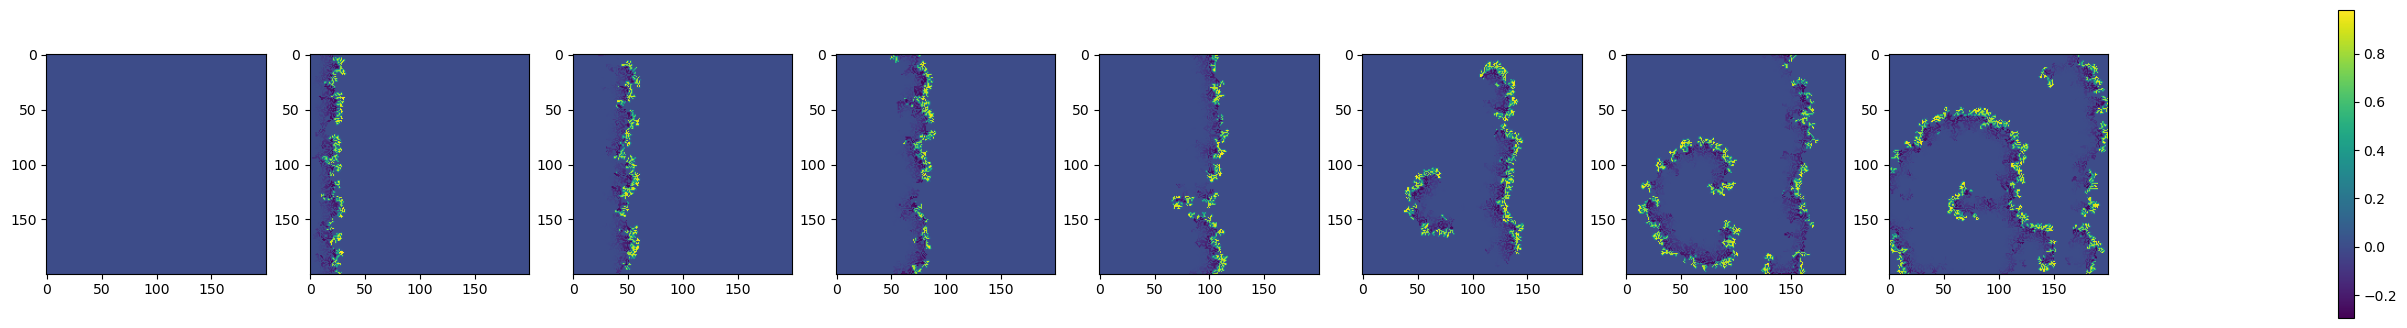

In [9]:
fig, axs = plt.subplots(1,9,figsize=(30,4))
min = sol.ys.min()
max = sol.ys.max()
for i, ax in enumerate(axs[:-1]):
    im = ax.imshow(sol.ys[int((i/len(axs)*len(sol.ts))),:N].reshape(N_x,N_y).T, vmin=min,vmax=max)
axs[-1].axis('off')
fig.colorbar(im, ax=axs[-1])

In [ ]:


# Euler-Maruyama implementation
def FHN_step(u, v, N, a, b, e, Du, sigma, L, key, delta_t):
    '''
    Perform a single step of the noisy FitzHugh-Nagumo model.
    Parameters:
    - u: state variable u
    - v: state variable v
    - N: number of nodes
    - a: parameter a
    - b: parameter b
    - e: parameter e giving the timescale separation between u and v
    - Du: Diffusion coefficient
    - sigma: noise intensity
    - L: Laplacian matrix
    - key: random key for noise generation
    - delta_t: time step
    Returns:
    - u_new: updated state variable u
    - v_new: updated state variable v
    '''
    # Generate Gaussian noise for each element of h
    noise = random.normal(key, u.shape)
    
    du = a * u * (u - b) * (1 - u) - Du * (L @ u) - v 
    dv = e * (u - v)
    u_new = u + du * delta_t + jnp.sqrt(delta_t * sigma**2) * noise
    v_new = v + dv * delta_t

    return u_new, v_new

def run_simulation(N=N, y0='wave', a=3, b=0.05, e=1e-2, Du=0.04, L=L1, c1=c1, sigma=0.0001, delta_t=0.1, total_time=3000.0, key=random.PRNGKey(0)):
    indices = jnp.where((jnp.arange(N) % 200 == 0) & (c1.flatten() == 0))[0]
    if y0 == 'wave':
        y0 = jnp.zeros(2 * N, dtype=jnp.float32)
        y0 = y0.at[indices].set(0.1)

    # Calculate the number of steps based on the total time and delta_t
    num_steps = int(total_time / delta_t)
    
    # Initialize state variables
    u = y0[:N]
    v = y0[N:]

    # Define the scan function
    def scan_fn(carry, _):
        u, v, key = carry
        key, subkey = random.split(key)
        u, v = FHN_step(u, v, N, a, b, e, Du, sigma, L, subkey, delta_t)
        return (u, v, key), (u, v)

    # Run the scan function
    (u, v, _), (u_trajectory, v_trajectory) = lax.scan(scan_fn, (u, v, key), None, length=num_steps)

    # Return values every 10 timesteps
    u_trajectory = u_trajectory[::10]
    v_trajectory = v_trajectory[::10]

    return u_trajectory, v_trajectory



In [5]:
L1, c1 = generate_laplacian(N_x, N_x, conduction_block_threshold=0.5, sparse_matrix=True, seed=2)
u_sol, v_sol = run_simulation(N=N, sigma=0.0001,L=L1, c1=c1, key=random.PRNGKey(2),delta_t=0.1, total_time=3000)


In [49]:
u_diffrax = sol.ys[:,:N].T
v_diffrax = sol.ys[:,N:].T

Text(0, 0.5, 'u')

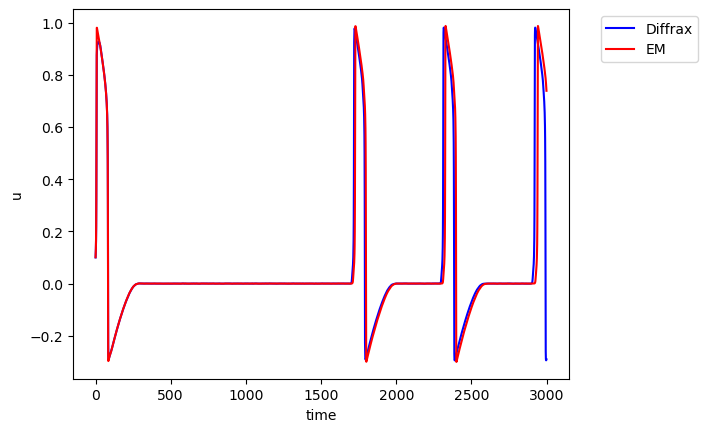

In [ ]:
#plot u for a single element for both methods

plt.plot(u_diffrax[2000,:], c='b', label='Diffrax')
plt.plot(u_sol[:,2000], c='r', label='EM')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('time')
plt.ylabel('u')

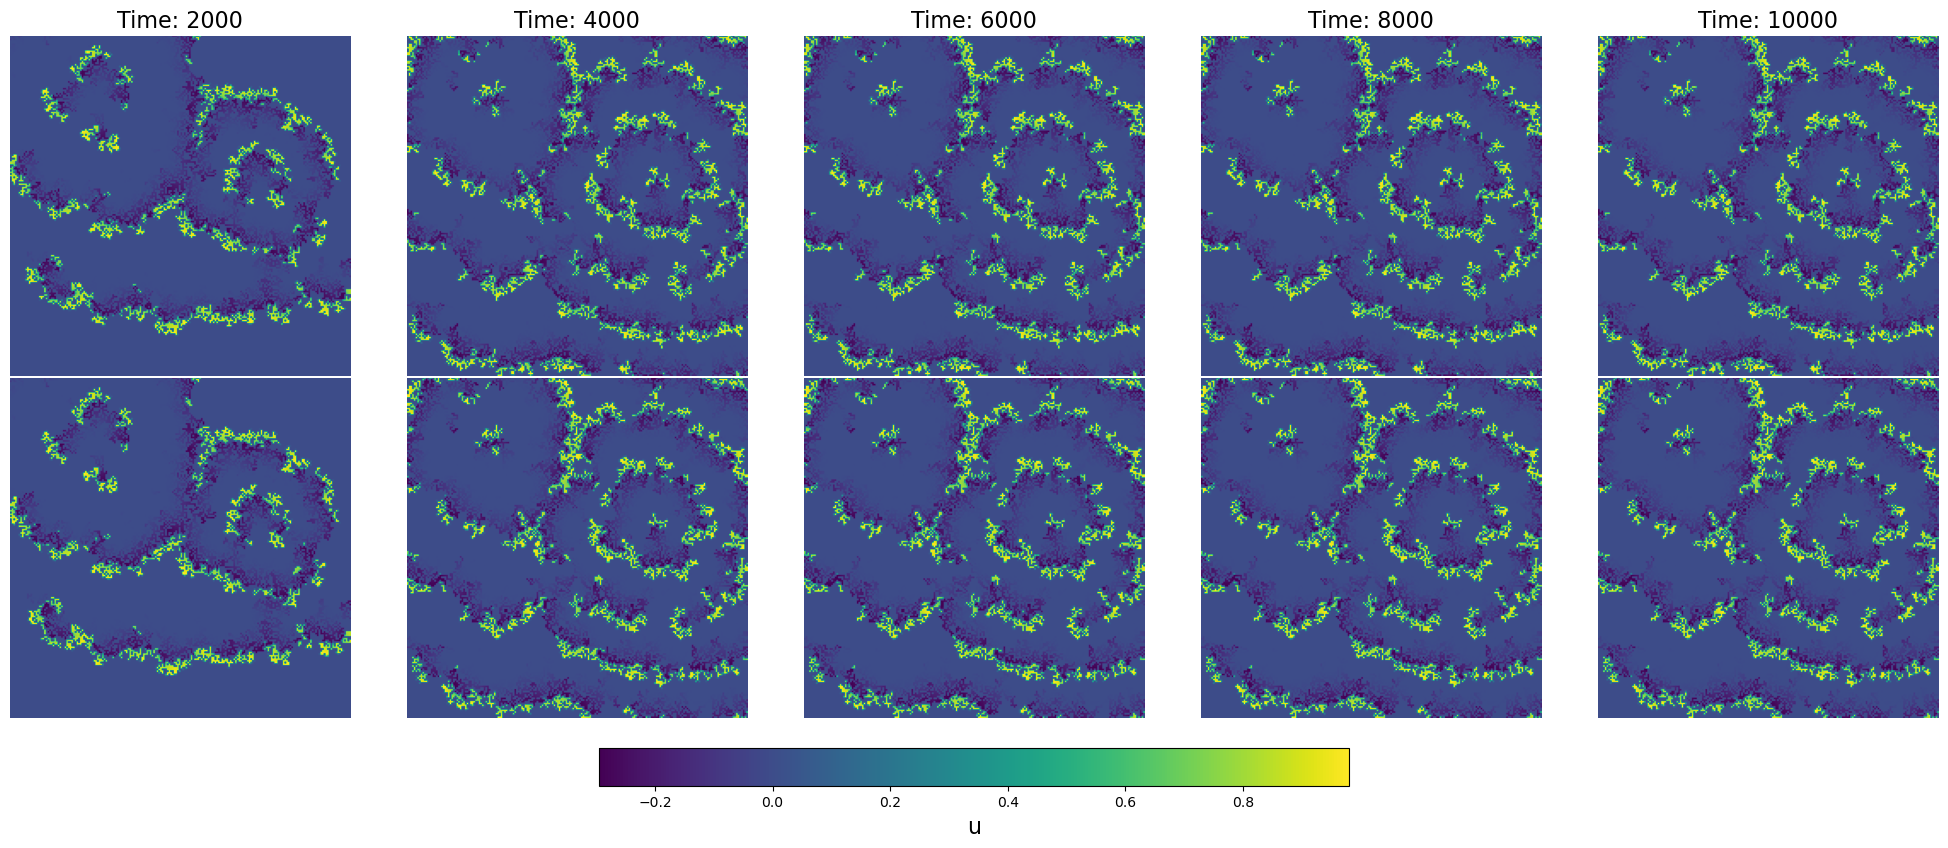

In [46]:


timesteps = [2000, 4000, 6000, 8000, 10000]  # Example timesteps to plot
fig, axs = plt.subplots(2, len(timesteps), figsize=(20, 8))

for i, t in enumerate(timesteps):
    im1 = axs[0, i].imshow(u_diffrax[:, t].reshape(N_x, N_y).T, vmin=min, vmax=max)
    axs[0, i].axis('off')
    axs[0, i].set_title(f'Time: {t}', fontsize=16)  # Add time labels as titles
    
    im2 = axs[1, i].imshow(u_sol[t, :].reshape(N_x, N_y).T, vmin=min, vmax=max)
    axs[1, i].axis('off')

# Add labels for the rows
axs[0, 0].set_ylabel('u_diffrax', fontsize=16)
axs[1, 0].set_ylabel('u_sol', fontsize=16)

# Adjust layout to make room for the labels
plt.tight_layout()

# Create a single colorbar for both sets of subplots
cbar = fig.colorbar(im1, ax=axs, orientation='horizontal', fraction=0.05, pad=0.04)
cbar.set_label('u', fontsize=16)

plt.show()

In [ ]:
def are_statistically_comparable(mean1, variance1, mean2, variance2, std_error_mean1, std_error_mean2, n1, n2):
    ''''
    Function to compare two sets of means and variances using z-tests.
    Parameters:
    - mean1: mean of the first set of data
    - variance1: variance of the first set of data
    - mean2: mean of the second set of data
    - variance2: variance of the second set of data
    - std_error_mean1: standard error of the mean for the first set of data
    - std_error_mean2: standard error of the mean for the second set of data
    - n1: number of samples in the first set of data
    - n2: number of samples in the second set of data
    Returns:
    - mean_comparable: boolean indicating whether the means are comparable
    - variance_comparable: boolean indicating whether the variances are comparable
    ''''
    # Calculate the z-score for the means
    z_mean = (mean1 - mean2) / jnp.sqrt(std_error_mean1**2 + std_error_mean2**2)

    # Calculate the z-score for the variances
    z_variance = (variance1 - variance2) / jnp.sqrt((2 * (variance1**2) / (n1 - 1)) + (2 * (variance2**2) / (n2 - 1)))

    # Define the threshold for the z-test (e.g., 1.96 for a 95% confidence interval)
    z_threshold = 1.96

    # Check if the absolute z-scores are within the threshold
    mean_comparable = jnp.abs(z_mean) < z_threshold
    variance_comparable = jnp.abs(z_variance) < z_threshold

    return mean_comparable, variance_comparable

def compute_statistics(data):
    '''
    Function to compute the mean, variance, and standard error of the mean for a given dataset.
    Parameters:
    - data: dataset for which to compute statistics. 2d array 
    Returns:
    - mean: mean of the dataset
    - variance: variance of the dataset
    - std_error_mean: standard error of the mean of the dataset
    -std_error_variance: standard error of the variance of the dataset
    '''
    mean = jnp.mean(data)
    variance = jnp.var(data)
    std_error_mean = jnp.std(data) / jnp.sqrt(data.shape[0] * data.shape[1])
    std_error_variance = jnp.sqrt(2 * (variance ** 2) / ((data.shape[0] - 1) * (data.shape[1] - 1)))
    return mean, variance, std_error_mean, std_error_variance



In [ ]:


# Compute statistics for u_sol and u_diffrax
u_sol_mean, u_sol_variance, u_sol_std_error_mean, u_sol_std_error_variance = compute_statistics(u_sol.T)
u_diffrax_mean, u_diffrax_variance, u_diffrax_std_error_mean, u_diffrax_std_error_variance = compute_statistics(u_diffrax)

# Compute statistics for v_sol and v_diffrax
v_sol_mean, v_sol_variance, v_sol_std_error_mean, v_sol_std_error_variance = compute_statistics(v_sol.T)
v_diffrax_mean, v_diffrax_variance, v_diffrax_std_error_mean, v_diffrax_std_error_variance = compute_statistics(v_diffrax)

# Check if u_sol and u_diffrax are statistically comparable
u_mean_comparable, u_variance_comparable = are_statistically_comparable(
    u_sol_mean, u_sol_variance, u_diffrax_mean, u_diffrax_variance, u_sol_std_error_mean, u_diffrax_std_error_mean, 200*200*3000,200*200*3000
)

# Check if v_sol and v_diffrax are statistically comparable
v_mean_comparable, v_variance_comparable = are_statistically_comparable(
    v_sol_mean, v_sol_variance, v_diffrax_mean, v_diffrax_variance, v_sol_std_error_mean, v_diffrax_std_error_mean, 200*200*3000,200*200*3000
)

# Print the results
print("u mean comparable:", u_mean_comparable)
print("u variance comparable:", u_variance_comparable)
print("v mean comparable:", v_mean_comparable)
print("v variance comparable:", v_variance_comparable)
print("u_sol mean:", u_sol_mean)
print("u_sol variance:", u_sol_variance)
print("u_sol std error of mean:", u_sol_std_error_mean)
print("u_sol std error of variance:", u_sol_std_error_variance)
print("u_diffrax mean:", u_diffrax_mean)
print("u_diffrax variance:", u_diffrax_variance)
print("u_diffrax std error of mean:", u_diffrax_std_error_mean)
print("u_diffrax std error of variance:", u_diffrax_std_error_variance)

print("v_sol mean:", v_sol_mean)
print("v_sol variance:", v_sol_variance)
print("v_sol std error of mean:", v_sol_std_error_mean)
print("v_sol std error of variance:", v_sol_std_error_variance)

print("v_diffrax mean:", v_diffrax_mean)
print("v_diffrax variance:", v_diffrax_variance)
print("v_diffrax std error of mean:", v_diffrax_std_error_mean)
print("v_diffrax std error of variance:", v_diffrax_std_error_variance)

u mean comparable: False
u variance comparable: True
v mean comparable: False
v variance comparable: True
u_sol mean: 0.021658905
u_sol variance: 0.029514445
u_sol std error of mean: 1.5682912e-05
u_sol std error of variance: 3.8109813e-06
u_diffrax mean: 0.021895604
u_diffrax variance: 0.029746654
u_diffrax std error of mean: 1.5744485e-05
u_diffrax std error of variance: 3.840965e-06
v_sol mean: 0.020223677
v_sol variance: 0.005260774
v_sol std error of mean: 6.621162e-06
v_sol std error of variance: 6.792847e-07
v_diffrax mean: 0.020457305
v_diffrax variance: 0.0053116363
v_diffrax std error of mean: 6.6530924e-06
v_diffrax std error of variance: 6.8585217e-07


In [ ]:
def threshold_matrix(matrix: jnp.ndarray, threshold: float) -> jnp.ndarray:
    """
    Scans a JAX matrix and returns a binary matrix where elements above 
    the threshold are 1 and elements below or equal to the threshold are 0.
    
    Parameters:
    matrix (jnp.ndarray): Input JAX matrix.
    threshold (float): Threshold value.
    
    Returns:
    jnp.ndarray: A binary matrix of the same shape as the input.
    """
    # Use jax.numpy.where to create a binary matrix
    return jnp.where(matrix > threshold, 1, 0)
@jit
def activity_calc(rate, c1): 
    '''
    Function to calculate the activity of the network (average over the lattice sites of the binarised u) based on the rate matrix and the conduction block matrix.
    Parameters:
    - rate: rate matrix of the network. 2d jnp.ndarray of shape (T, N).
    - c1: conduction block matrix. 2d jnp.ndarray of shape (N_x, N_y).
    Returns:
    - activity: activity of the network. 1d jnp.ndarray of shape (T,).
''' 
    # Broadcast c1 to match the shape of rate
    rate=threshold_matrix(rate,0.08)
    rate=rate.T
    rate=rate.reshape((N_x,N_y,-1))
    c1=c1[4:N_x-4, 4:N_y-4]
    rate=rate[4:N_x-4, 4:N_y-4, :]
    c1_broadcasted = jnp.broadcast_to(c1[:, :, None], rate.shape)
    masked_rate = jnp.where(c1_broadcasted, jnp.nan, rate)
    masked_rate = masked_rate.reshape((N_x-8) * (N_y-8), -1)
    activity = jnp.nanmean(masked_rate, axis=0)
    

    return activity




In [55]:
rate_diffrax = threshold_matrix(u_diffrax.T, 0.08)
rate_diffrax=rate_diffrax.T
rate_diffrax = rate_diffrax.reshape(N_x, N_y, -1)
activity_diffrax = activity_calc(rate_diffrax, c1)

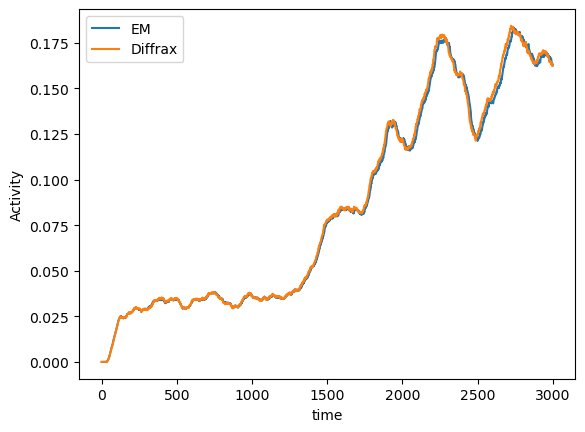

In [56]:
rate_EM = threshold_matrix(u_sol, 0.08)
rate_EM = rate_EM.T
rate_EM = rate_EM.reshape(N_x, N_y, -1)
activity_EM = activity_calc(rate_EM, c1)
plt.plot(activity_EM, label='EM')
plt.plot(activity_diffrax, label='Diffrax')
plt.xlabel('time')
plt.ylabel('Activity')
plt.legend()

In [ ]:
def compute_statistics_act(data):
    '''
    Function to compute the mean, variance, and standard error of the mean for a given dataset.
    Parameters:
    - data: dataset for which to compute statistics. 1d array
    Returns:
    - mean: mean of the dataset
    - variance: variance of the dataset
    - std_error_mean: standard error of the mean of the dataset
    -std_error_variance: standard error of the variance of the dataset
    '''
    
    mean = jnp.mean(data)
    variance = jnp.var(data)
    std_error_mean = jnp.std(data) / jnp.sqrt(data.shape[0])
    std_error_variance = jnp.sqrt(2 * (variance ** 2) / ((data.shape[0] - 1) ))
    return mean, variance, std_error_mean, std_error_variance

In [ ]:


act_sol_mean, act_sol_variance, act_sol_std_error_mean, act_sol_std_error_variance = compute_statistics_act(activity_EM)
act_diffrax_mean, act_diffrax_variance, act_diffrax_std_error_mean, act_diffrax_std_error_variance = compute_statistics_act(activity_diffrax)
act_mean_comparable, act_variance_comparable = are_statistically_comparable(act_sol_mean, act_sol_variance, act_diffrax_mean, act_diffrax_variance, act_sol_std_error_mean, act_diffrax_std_error_mean,3000,300)
print("Activity mean comparable:", act_mean_comparable)
print("Activity variance comparable:", act_variance_comparable)
print("EM mean:", act_sol_mean)
print("EM variance:", act_sol_variance)
print("EM std error of mean:", act_sol_std_error_mean)
print("EM std error of variance:", act_sol_std_error_variance)
print("Diffrax mean:", act_diffrax_mean)
print("Diffrax variance:", act_diffrax_variance)
print("Diffrax std error of mean:", act_diffrax_std_error_mean)
print("Diffrax std error of variance:", act_diffrax_std_error_variance)


Activity mean comparable: True
Activity variance comparable: True
EM mean: 0.084537424
EM variance: 0.0031802899
EM std error of mean: 0.0010296099
EM std error of variance: 8.212842e-05
Diffrax mean: 0.0853725
Diffrax variance: 0.0032470594
Diffrax std error of mean: 0.001040362
Diffrax std error of variance: 8.385269e-05


# Different time steps

In [ ]:
#simulation for different time steps
u_sol4,v_sol4 = run_simulation(N=N, sigma=0.0001,L=L1, c1=c1, key=random.PRNGKey(2),delta_t=0.08, total_time=3000)
u_sol5,v_sol5 = run_simulation(N=N, sigma=0.0001,L=L1, c1=c1, key=random.PRNGKey(2),delta_t=0.12, total_time=3000)

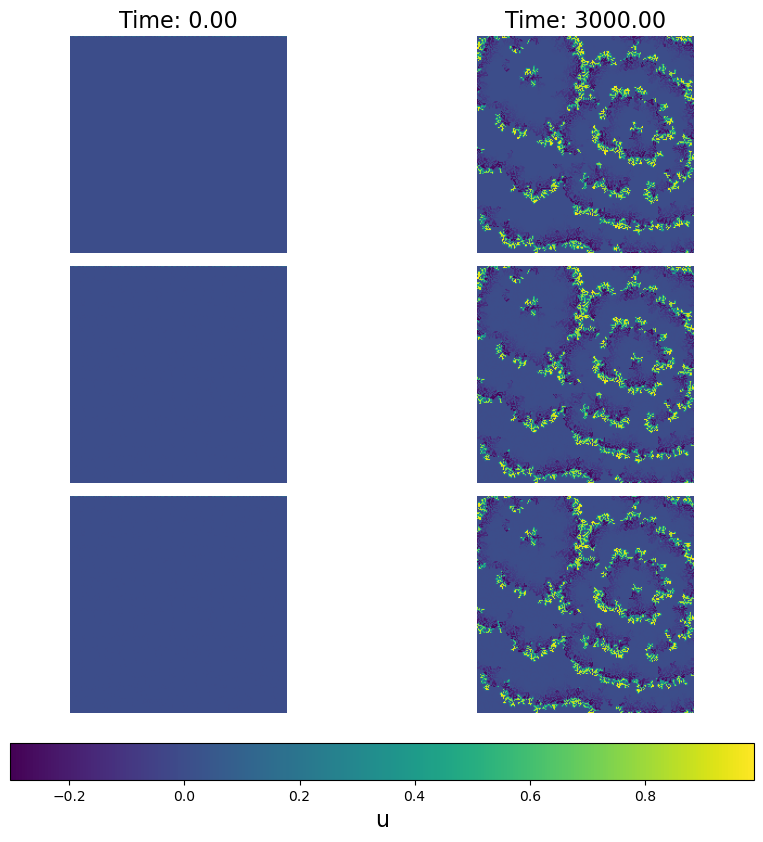

In [16]:


# Define the timesteps for each array
timesteps_08 = np.linspace(0, 3000, int(3000 / (0.08 * 10)))
timesteps_10 = np.linspace(0, 3000, int(3000 / (0.10 * 10)))
timesteps_12 = np.linspace(0, 3000, int(3000 / (0.12 * 10)))

# Find common time values
common_times = np.intersect1d(np.intersect1d(timesteps_08, timesteps_10), timesteps_12)

# Find corresponding indices in each array
indices_08 = [np.where(timesteps_08 == t)[0][0] for t in common_times]
indices_10 = [np.where(timesteps_10 == t)[0][0] for t in common_times]
indices_12 = [np.where(timesteps_12 == t)[0][0] for t in common_times]
# Plotting the results
fig, axs = plt.subplots(3, len(common_times), figsize=(10, 8))

for i, (idx_08, idx_10, idx_12) in enumerate(zip(indices_08, indices_10, indices_12)):
    im1 = axs[0, i].imshow(u_sol4[idx_08, :].reshape(N_x,N_y).T, vmin=u_sol4.min(), vmax=u_sol4.max())
    axs[0, i].axis('off')
    axs[0, i].set_title(f'Time: {common_times[i]:.2f}', fontsize=16)
    
    im2 = axs[1, i].imshow(u_sol[idx_10, :].reshape(N_y,N_y).T, vmin=u_sol.min(), vmax=u_sol.max())
    axs[1, i].axis('off')
    
    im3 = axs[2, i].imshow(u_sol5[idx_12, :].reshape(N_x, N_y).T, vmin=u_sol5.min(), vmax=u_sol5.max())
    axs[2, i].axis('off')
plt.tight_layout()

# Create a single colorbar for all sets of subplots
cbar = fig.colorbar(im1, ax=axs, orientation='horizontal', fraction=0.05, pad=0.04)
cbar.set_label('u', fontsize=16)

# Adjust layout to make room for the time arrow
plt.show()

Text(0, 0.5, 'u')

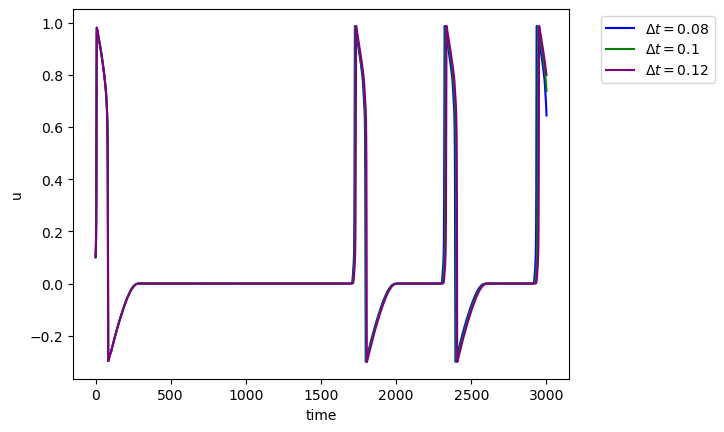

In [78]:
plt.plot(np.linspace(0, 3000, int(3000 / (0.08*10 ))),u_sol4[:,2000], c='b', label=r'$\Delta t = 0.08$')
#plt.plot(np.linspace(0, 3000, int(3000 / (0.09*10 ))),u_sol3[:,2000], c='r', label=r'$\Delta t = 0.09$')
plt.plot(np.linspace(0, 3000, int(3000 / (0.1*10 ))),u_sol[:,2000], c='g', label=r'$\Delta t = 0.1$')
#plt.plot(np.linspace(0, 3000, int(3000 / (0.11*10 ))),u_sol2[:,2000], c='orange', label=r'$\Delta t = 0.11$')
plt.plot(np.linspace(0, 3000, int(3000 / (0.12*10 ))),u_sol5[:,2000], c='purple', label=r'$\Delta t = 0.12$')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('time')
plt.ylabel('u')

In [25]:
# Compute statistics for u_sol, u_sol4, and u_sol5
u_sol_mean, u_sol_variance, u_sol_std_error_mean, u_sol_std_error_variance = compute_statistics(u_sol.T)
u_sol4_mean, u_sol4_variance, u_sol4_std_error_mean, u_sol4_std_error_variance = compute_statistics(u_sol4.T)
u_sol5_mean, u_sol5_variance, u_sol5_std_error_mean, u_sol5_std_error_variance = compute_statistics(u_sol5.T)

# Check if u_sol and u_sol4 are statistically comparable
u_sol4_mean_comparable, u_sol4_variance_comparable = are_statistically_comparable(
    u_sol_mean, u_sol_variance, u_sol4_mean, u_sol4_variance, u_sol_std_error_mean, u_sol4_std_error_mean, 200*200*3000, 200*200*3000
)

# Check if u_sol and u_sol5 are statistically comparable
u_sol5_mean_comparable, u_sol5_variance_comparable = are_statistically_comparable(
    u_sol_mean, u_sol_variance, u_sol5_mean, u_sol5_variance, u_sol_std_error_mean, u_sol5_std_error_mean,200*200*3000,200*200*3000
)

# Print the results
print("u_sol mean:", u_sol_mean)
print("u_sol variance:", u_sol_variance)
print("u_sol std error of mean:", u_sol_std_error_mean)
print("u_sol std error of variance:", u_sol_std_error_variance)

print("u_sol4 mean:", u_sol4_mean)
print("u_sol4 variance:", u_sol4_variance)
print("u_sol4 std error of mean:", u_sol4_std_error_mean)
print("u_sol4 std error of variance:", u_sol4_std_error_variance)

print("u_sol5 mean:", u_sol5_mean)
print("u_sol5 variance:", u_sol5_variance)
print("u_sol5 std error of mean:", u_sol5_std_error_mean)
print("u_sol5 std error of variance:", u_sol5_std_error_variance)

print("u_sol and u_sol4 mean comparable:", u_sol4_mean_comparable)
print("u_sol and u_sol4 variance comparable:", u_sol4_variance_comparable)

print("u_sol and u_sol5 mean comparable:", u_sol5_mean_comparable)
print("u_sol and u_sol5 variance comparable:", u_sol5_variance_comparable)

u_sol mean: 0.021658905
u_sol variance: 0.029514445
u_sol std error of mean: 1.5682912e-05
u_sol std error of variance: 3.8109813e-06
u_sol4 mean: 0.02176912
u_sol4 variance: 0.02967638
u_sol4 std error of mean: 1.4065651e-05
u_sol4 std error of variance: 3.427233e-06
u_sol5 mean: 0.0215452
u_sol5 variance: 0.029351752
u_sol5 std error of mean: 1.7132354e-05
u_sol5 std error of variance: 4.151847e-06
u_sol and u_sol4 mean comparable: False
u_sol and u_sol4 variance comparable: False
u_sol and u_sol5 mean comparable: False
u_sol and u_sol5 variance comparable: False


Text(0, 0.5, 'Activity')

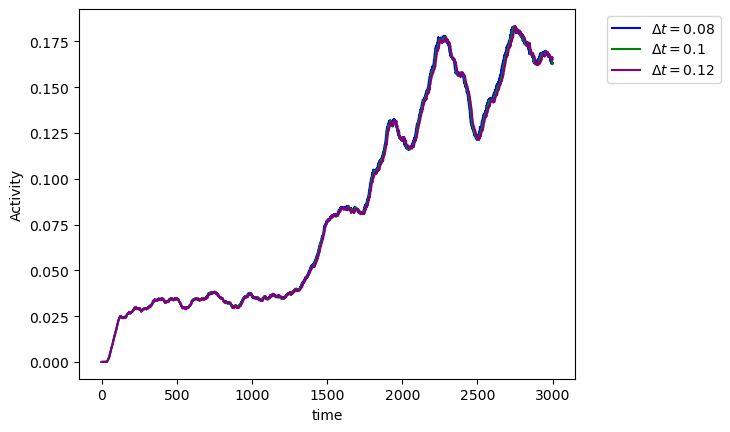

In [19]:
act4=activity_calc(u_sol4, c1)
act=activity_calc(u_sol, c1)

act5=activity_calc(u_sol5, c1)

plt.plot(np.linspace(0, 3000, int(3000 / (0.08*10 ))),act4, c='b', label=r'$\Delta t = 0.08$')
#plt.plot(act3, c='r', label=r'$\Delta t = 0.09$')
plt.plot(np.linspace(0, 3000, int(3000 / (0.1*10 ))),act, c='g', label=r'$\Delta t = 0.1$')
#plt.plot(act2, c='orange', label=r'$\Delta t = 0.11$')
plt.plot(np.linspace(0, 3000, int(3000 / (0.12*10 ))),act5, c='purple', label=r'$\Delta t = 0.12$')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('time')
plt.ylabel('Activity')



In [26]:
# Compute statistics for act, act4, and act5
act_mean, act_variance, act_std_error_mean, act_std_error_variance = compute_statistics_act(act)
act4_mean, act4_variance, act4_std_error_mean, act4_std_error_variance = compute_statistics_act(act4)
act5_mean, act5_variance, act5_std_error_mean, act5_std_error_variance = compute_statistics_act(act5)

# Check if act and act4 are statistically comparable
act4_mean_comparable, act4_variance_comparable = are_statistically_comparable(
    act_mean, act_variance, act4_mean, act4_variance, act_std_error_mean, act4_std_error_mean,3000,3000
)

# Check if act and act5 are statistically comparable
act5_mean_comparable, act5_variance_comparable = are_statistically_comparable(
    act_mean, act_variance, act5_mean, act5_variance, act_std_error_mean, act5_std_error_mean, 3000, 3000
)

# Print the results
print("act mean:", act_mean)
print("act variance:", act_variance)
print("act std error of mean:", act_std_error_mean)
print("act std error of variance:", act_std_error_variance)

print("act4 mean:", act4_mean)
print("act4 variance:", act4_variance)
print("act4 std error of mean:", act4_std_error_mean)
print("act4 std error of variance:", act4_std_error_variance)

print("act5 mean:", act5_mean)
print("act5 variance:", act5_variance)
print("act5 std error of mean:", act5_std_error_mean)
print("act5 std error of variance:", act5_std_error_variance)

print("act and act4 mean comparable:", act4_mean_comparable)
print("act and act4 variance comparable:", act4_variance_comparable)

print("act and act5 mean comparable:", act5_mean_comparable)
print("act and act5 variance comparable:", act5_variance_comparable)

act mean: 0.084537424
act variance: 0.0031802899
act std error of mean: 0.0010296099
act std error of variance: 8.212842e-05
act4 mean: 0.08494769
act4 variance: 0.0032015503
act4 std error of mean: 0.00092398416
act4 std error of variance: 7.3946496e-05
act5 mean: 0.08413645
act5 variance: 0.003156213
act5 std error of mean: 0.0011236037
act5 std error of variance: 8.9289046e-05
act and act4 mean comparable: True
act and act4 variance comparable: True
act and act5 mean comparable: True
act and act5 variance comparable: True
